In [1]:
import os 
import sys
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle as pk
from keras.models import Sequential,Model
from keras.layers import Reshape, Dropout, Dense, Activation, BatchNormalization,Input,CuDNNLSTM
from keras.layers import Conv2D, ZeroPadding2D,GlobalAveragePooling2D,Flatten,LSTM,Concatenate
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import pdb




Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:

iq_data = pk.load(open('/content/gdrive/My Drive/Colab Notebooks/RML2016.10b.dat','rb'),encoding ='latin1')


print('Dataset imported')
##### from radioML https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb

snrs,modulation = map(lambda j: sorted(list(set(map(lambda x: x[j], iq_data.keys())))), [1,0])


print('Modulation labels: {}'.format(modulation))
print('SNR values for each modulation: {}'.format(snrs))

x_data = []
label = []
for m in modulation:
  for snr in snrs:
    x_data.append(iq_data[(m,snr)])
    for l in np.arange(iq_data[(m,snr)].shape[0]):
      label.append((m,snr))

x_stacked = np.vstack(x_data)
#####

print('Dataset shape: {}'.format(x_stacked.shape))



Dataset imported
Modulation labels: ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
SNR values for each modulation: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Dataset shape: (1200000, 2, 128)


In [0]:

np.random.seed(200)
N_samples = x_stacked.shape[0]

N_train = int(N_samples*0.7)

train_Idx = np.random.choice(np.arange(N_samples),size=N_train,replace=False)

total_N = np.arange(N_samples)

test_Idx = list(set(total_N)-set(train_Idx))

x_train = x_stacked[train_Idx]
x_test = x_stacked[test_Idx]

In [0]:
input_encode = lambda x: modulation.index(label[x][0])
y_list_train= np.array(list(map(input_encode,train_Idx)),dtype='float32')
y_list_test = np.array(list(map(input_encode,test_Idx)),dtype='float32')
y_train = to_categorical(y_list_train,len(modulation))
y_test= to_categorical(y_list_test,len(modulation))


In [7]:
print('Number of Samples, height, width')
print(x_train.shape)

N,H,W = x_train.shape
N_test = x_test.shape[0]
C = 1

x_train = x_train.reshape(N,H,W,C)
x_test  = x_test.reshape(N_test,H,W,C)
print(x_train.shape,x_test.shape)
input_sample = list(x_train.shape[1:])



Number of Samples, height, width
(840000, 2, 128)
(840000, 2, 128, 1) (360000, 2, 128, 1)


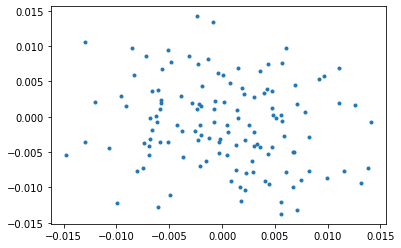

In [9]:
plt.plot(x_train[0,0,:],x_train[0,1,:],'.')

In [10]:

input_dim =Input(shape=input_sample,name = 'LSTM_architecture')
zero_pad_1 = ZeroPadding2D(padding =(0,2),data_format='channels_last')(input_dim)
conv_1 = Conv2D(64,(1,5),activation= 'relu',data_format='channels_last')(zero_pad_1)
drop_1 = Dropout(0.2)(conv_1)
zero_pad_2 = ZeroPadding2D((0,2),data_format='channels_last')(drop_1)
conv_2 = Conv2D(64,(1,5),activation= 'relu',data_format='channels_last')(zero_pad_2)
drop_2 = Dropout(0.2)(conv_2)
merge = Concatenate(axis=2)([drop_1,drop_2])
merge_size = list(np.shape(merge))
_,concat_h,concat_w,units = np.shape(merge)
dimensions = int(concat_h)*int(concat_w)
units = int(units)
resh_model = Reshape((units,dimensions))(merge)
lstm = CuDNNLSTM(64)(resh_model)
fc_1 = Dense(128,activation='relu')(lstm)
out_layer =Dense(len(modulation),activation='softmax')(fc_1)
model = Model(inputs=input_dim, outputs=out_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LSTM_architecture (InputLayer)  (None, 2, 128, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 2, 132, 1)    0           LSTM_architecture[0][0]          
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2, 128, 64)   384         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2, 128, 64)   0           conv2

In [11]:
epoch = 55
batch = 1024
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/Colab Notebooks/LSTM_weights.best.hdf5", monitor='loss',
    save_best_only=True, mode='auto')

start_run =model.fit(x_train,y_train,batch_size=batch,epochs=epoch,verbose=2,validation_data=(x_test,y_test), callbacks=[checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 840000 samples, validate on 360000 samples
Epoch 1/55





 - 97s - loss: 1.6644 - acc: 0.3269 - val_loss: 1.4035 - val_acc: 0.4200
Epoch 2/55
 - 82s - loss: 1.3067 - acc: 0.4643 - val_loss: 1.2495 - val_acc: 0.4855
Epoch 3/55
 - 82s - loss: 1.2364 - acc: 0.4913 - val_loss: 1.2383 - val_acc: 0.4948
Epoch 4/55
 - 83s - loss: 1.2050 - acc: 0.5042 - val_loss: 1.1728 - val_acc: 0.5188
Epoch 5/55
 - 83s - loss: 1.1863 - acc: 0.5122 - val_loss: 1.1797 - val_acc: 0.5138
Epoch 6/55
 - 83s - loss: 1.1657 - acc: 0.5202 - val_loss: 1.1433 - val_acc: 0.5278
Epoch 7/55
 - 83s - loss: 1.1527 - acc: 0.5248 - val_loss: 1.1311 - val_acc: 0.5332
Epoch 8/55
 - 83s - loss: 1.1412 - acc: 0.5295 - val_loss: 1.1428 - val_acc: 0.5254
Epoch 9/55
 - 83s - loss: 1.1327 - acc: 0.5329 - val_loss: 1.1435 - val_acc: 0.5289
Epoch 10/55
 - 83s - loss: 1.1264 - acc: 0.5355 - val_loss: 1.1137 - val_acc: 0.5405
Epoch

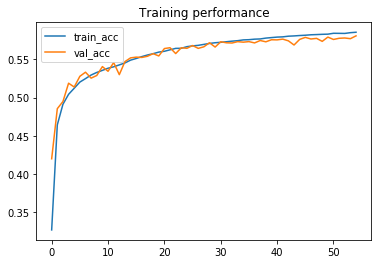

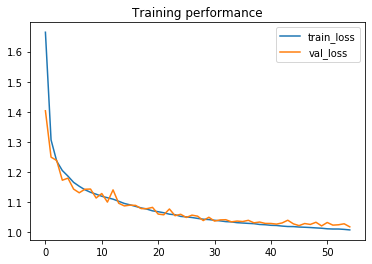

In [12]:
plt.figure()
plt.title('Training performance')
plt.plot(start_run.epoch, start_run.history['acc'], label='train_acc')
plt.plot(start_run.epoch, start_run.history['val_acc'], label='val_acc')
plt.legend()

plt.figure()
plt.title('Training performance')
plt.plot(start_run.epoch, start_run.history['loss'], label='train_loss')
plt.plot(start_run.epoch, start_run.history['val_loss'], label='val_loss')
plt.legend()

In [13]:
from sklearn.metrics import confusion_matrix
batch = 1024
model.load_weights("/content/gdrive/My Drive/Colab Notebooks/LSTM_weights.best.hdf5")

score = model.evaluate(x_test, y_test, verbose=0, batch_size=batch)
print(score)


[1.0179379428393105, 0.5806861111111111]


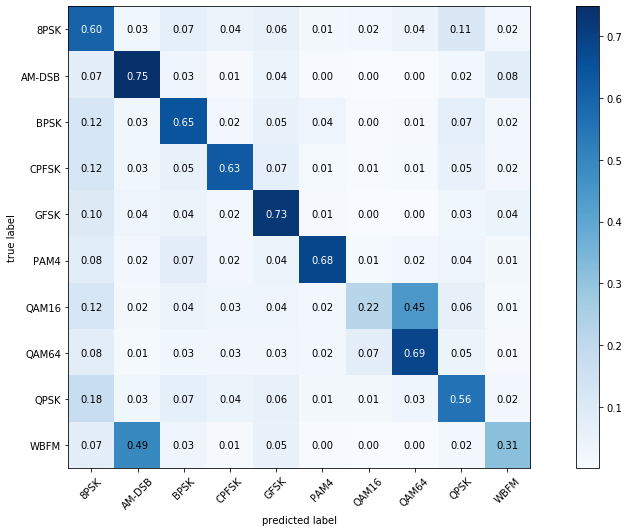

In [14]:
y_pred = model.predict(x_test,batch)
y_pred_label = np.argmax(y_pred,axis=1)
y_test_label = np.argmax(y_test,axis=1)


cm = confusion_matrix(y_test_label,y_pred_label, normalize= 'true')
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test_label,y_pred_label)
fg, ax = plot_confusion_matrix(cm,colorbar=True,
                                show_absolute=False,
                                show_normed=True)


ax.set_xticks(np.arange(len(modulation)))
ax.set_xticklabels(modulation, rotation = 45)

ax.set_yticks(np.arange(len(modulation)))
ax.set_yticklabels(modulation)

fg.set_size_inches(16.5, 8.5, forward=True)
